# Heart disease prediction

Data set source: https://www.kaggle.com/fedesoriano/heart-failure-prediction

**Attribute information:**
1. **Age**: Age of the patient [years]
2. **Sex**: Sex of the patient [M: Male, F: Female]
3. **ChestPainType**: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. **RestingBP**: Resting blood pressure [mm Hg]
5. **Cholesterol**: Serum cholesterol [mm/dl]
6. **FastingBS**: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. **RestingECG**: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions 
    and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by 
    Estes' criteria]
8. **MaxHR**: Maximum heart rate achieved [Numeric value between 60 and 202]
9. **ExerciseAngina**: Exercise-induced angina [Y: Yes, N: No]
10. **Oldpeak**: ST [Numeric value measured in depression]
11. **ST_Slope**: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. **HeartDisease**: Output class [1: heart disease, 0: Normal]

The data set describes a classification problem in which we have to predict whether a person has an heart disease or not based on the above features.

---------------------------------------------------------------------------------------------------------------------

Import relevant libraries and load data:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate


import plotly.express as px

#importing plotly and cufflinks in offline mode
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
# Load data
heart_disease = pd.read_csv("heart.csv")

## 1. Exploratory data analysis (EDA):

Preview of 5 first observations:

In [3]:
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Define the type of the features:

In [4]:
categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
continuous_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Examine the shape of the data set:

In [5]:
shape = heart_disease.shape
print(f"The shape of the data is: {shape}")
print(f"Number of samples: {shape[0]}")
print(f"Number of features: {shape[1] - 1}")

The shape of the data is: (918, 12)
Number of samples: 918
Number of features: 11


Find if data contains duplicated rows:

In [6]:
print(f"Number of duplicated samples is: {heart_disease.duplicated().sum()}")

Number of duplicated samples is: 0


Check for missing values:

In [7]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
heart_disease[categorical_features].iplot(kind='histogram',subplots=True,bins=50)

The distribution of the continuous features is as follows: 

In [9]:
heart_disease[continuous_features].iplot(kind='histogram',subplots=True,bins=50)

We can see that there are unexpected values in 'Cholesterol' and 'RestingBP', we will check the statistical description of these features to get a better understanding:

In [10]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The minimal value of 'Cholesterol' and 'RestingBP' is 0 which is not valid, thus we'll consider it as a missing value. for that purpose we'll replace all zero values in 'Cholesterol' and 'RestingBP' to NaN:

In [11]:
cols = ["RestingBP", "Cholesterol"]
heart_disease[cols] = heart_disease[cols].replace({0:np.nan})
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,917.000000,746.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,244.635389,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.999749,59.153524,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,207.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,275.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Now we are able to see that the values for 'Cholesterol' and 'RestingBP' are at normal range.
In addition we can see that we now have missing values in our data set:

In [12]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

### Checking target imbalance:

<AxesSubplot:xlabel='HeartDisease', ylabel='Count'>

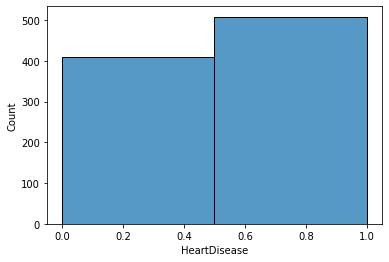

In [13]:
sns.histplot(heart_disease.HeartDisease, bins=2)

The percentage of each of the possible outputs is:

In [14]:
heart_disease['HeartDisease'].value_counts(normalize=True) * 100

1    55.337691
0    44.662309
Name: HeartDisease, dtype: float64

We can see that the data is balanced, which means that we can use 'accuracy' as our evaluation metric.

## 2. Data preprocess:

### Encoding Categorical Values:

In [15]:
heart_disease.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Check if all categorical features are assignd with values that they supposed to get.

In [16]:
for col in categorical_features:
    print(f"\nThe distribution of categorical valeus in '{col}' feature is:")
    print(heart_disease[col].value_counts())


The distribution of categorical valeus in 'Sex' feature is:
M    725
F    193
Name: Sex, dtype: int64

The distribution of categorical valeus in 'ChestPainType' feature is:
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

The distribution of categorical valeus in 'FastingBS' feature is:
0    704
1    214
Name: FastingBS, dtype: int64

The distribution of categorical valeus in 'RestingECG' feature is:
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

The distribution of categorical valeus in 'ExerciseAngina' feature is:
N    547
Y    371
Name: ExerciseAngina, dtype: int64

The distribution of categorical valeus in 'ST_Slope' feature is:
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64


In [17]:
# heart_disease["ST_Up_slope"] = np.where(obj_df["ST_Slope"].str.contains("Up"), 1, 0)
# for later if I want to change features semantic.

Use label encoding on 'Sex', 'ExerciseAngina' and 'ST_Slope':

In [18]:
cat_to_num = {
            "Sex": {"M": 0, "F": 1},
            "ExerciseAngina": {"N": 0, "Y": 1},
            "ChestPainType": {"ASY": 0, "TA": 1, "ATA": 2, "NAP": 3}
            }

In [19]:
heart_disease = heart_disease.replace(cat_to_num)
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,2,140.0,289.0,0,Normal,172,0,0.0,Up,0
1,49,1,3,160.0,180.0,0,Normal,156,0,1.0,Flat,1
2,37,0,2,130.0,283.0,0,ST,98,0,0.0,Up,0
3,48,1,0,138.0,214.0,0,Normal,108,1,1.5,Flat,1
4,54,0,3,150.0,195.0,0,Normal,122,0,0.0,Up,0


Perform one hot encoding to 'ChestPainType', 'RestingECG' and 'ST_Slope':

In [20]:
heart_disease = pd.get_dummies(heart_disease, columns=["RestingECG", "ST_Slope"], prefix=["R_ECG", "ST_Slope"])

# heart_disease = pd.get_dummies(heart_disease, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["CPT", "R_ECG", "ST_Slope"])
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,2,140.0,289.0,0,172,0,0.0,0,0,1,0,0,0,1
1,49,1,3,160.0,180.0,0,156,0,1.0,1,0,1,0,0,1,0
2,37,0,2,130.0,283.0,0,98,0,0.0,0,0,0,1,0,0,1
3,48,1,0,138.0,214.0,0,108,1,1.5,1,0,1,0,0,1,0
4,54,0,3,150.0,195.0,0,122,0,0.0,0,0,1,0,0,0,1


We can see now that we no longer have non-numeric data types in our data set:

In [21]:
heart_disease.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP         float64
Cholesterol       float64
FastingBS           int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
HeartDisease        int64
R_ECG_LVH           uint8
R_ECG_Normal        uint8
R_ECG_ST            uint8
ST_Slope_Down       uint8
ST_Slope_Flat       uint8
ST_Slope_Up         uint8
dtype: object

### Splitting dataset:

In [22]:
X = heart_disease.drop(["HeartDisease"], axis=1)
y = heart_disease["HeartDisease"]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [24]:
print(X_train.shape)
print(X_test.shape)
#X_train_scaled.head()

(734, 15)
(184, 15)


In [25]:
X_train_no_NaN = X_train.dropna()
y_train_no_NaN = y_train[X_train_no_NaN.index]
X_test_no_NaN = X_test.dropna()
y_test_no_NaN = y_test[X_test_no_NaN.index]

### Missing values:

In [26]:
X_train.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       145
FastingBS           0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
R_ECG_LVH           0
R_ECG_Normal        0
R_ECG_ST            0
ST_Slope_Down       0
ST_Slope_Flat       0
ST_Slope_Up         0
dtype: int64

To treat the missing value of 'RestingBP', we are going to remove the relevant sample:

In [27]:
# ind = np.where(X_train['RestingBP'].isnull())[0]
# X_train = X_train.dropna(subset=['RestingBP'])
# y_train = y_train[X_train.index]

In [28]:
X_train_RestingBP_median = X_train['RestingBP'].median()
X_train['RestingBP'] = X_train['RestingBP'].fillna(X_train_RestingBP_median)

We can see that the sample removal reduced the number of missing values (also in 'Cholesterol' column).

In [29]:
X_train.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       145
FastingBS           0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
R_ECG_LVH           0
R_ECG_Normal        0
R_ECG_ST            0
ST_Slope_Down       0
ST_Slope_Flat       0
ST_Slope_Up         0
dtype: int64

We are now going to take care of the missing values in 'Cholesterol' column. Before we do that, we'll first examine the feature's distribution:

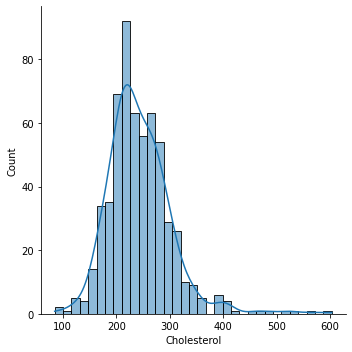

In [30]:
sns.displot(X_train.Cholesterol, kde= True)

We can see that the data is skewed and may contain outliers. Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values.When the data is skewed, it is good to consider using the median value for replacing the missing values.

In [31]:
X_train_cholesterol_median = X_train['Cholesterol'].median()
X_train['Cholesterol'] = X_train['Cholesterol'].fillna(X_train_cholesterol_median)

In [32]:
X_train.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
R_ECG_LVH         0
R_ECG_Normal      0
R_ECG_ST          0
ST_Slope_Down     0
ST_Slope_Flat     0
ST_Slope_Up       0
dtype: int64

In [33]:
X_train.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.284741,0.208447,1.098093,132.457766,242.243869,0.217984,137.555858,0.393733,0.906676,0.202997,0.604905,0.192098,0.068120,0.495913,0.435967
std,9.505473,0.406475,1.270366,17.759504,53.627477,0.413158,25.201053,0.488910,1.090713,0.402505,0.489205,0.394218,0.252123,0.500324,0.496221
min,28.000000,0.000000,0.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,0.000000,0.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,130.000000,236.000000,0.000000,139.000000,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,0.000000,2.000000,140.000000,264.750000,0.000000,157.000000,1.000000,1.500000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
X_test.isnull().sum()

Age                0
Sex                0
ChestPainType      0
RestingBP          0
Cholesterol       27
FastingBS          0
MaxHR              0
ExerciseAngina     0
Oldpeak            0
R_ECG_LVH          0
R_ECG_Normal       0
R_ECG_ST           0
ST_Slope_Down      0
ST_Slope_Flat      0
ST_Slope_Up        0
dtype: int64

In [35]:
X_test['Cholesterol'] = X_test['Cholesterol'].fillna(X_train_cholesterol_median)

### Outliers:

In [36]:
from scipy import stats
from scipy.stats import zscore

def remove_outliers(feature):
    z_scores = stats.zscore(X_train[feature])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    return X_train[filtered_entries]
     
for feature in continuous_features: 
    X_train_wo_outliers = remove_outliers(feature)
    y_train_wo_outliers = y_train[X_train_wo_outliers.index]
X_train_wo_outliers.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,53.273728,0.209078,1.107290,132.396149,242.191197,0.218707,137.592847,0.393398,0.878267,0.202201,0.607978,0.189821,0.063274,0.496561,0.440165
std,9.536542,0.406930,1.272528,17.674276,53.673516,0.413654,25.292544,0.488840,1.022095,0.401918,0.488538,0.392430,0.243622,0.500332,0.496749
min,28.000000,0.000000,0.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,0.000000,0.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,130.000000,236.000000,0.000000,139.000000,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,0.000000,2.000000,140.000000,264.000000,0.000000,157.500000,1.000000,1.500000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,202.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
X_train_wo_outliers.shape

(727, 15)

### Feature engineering:

In [38]:
# Didn't improve accuracy - 0.86 vs. 0.86

# heart_disease["MaxHR_precent"] = (heart_disease["MaxHR"] / (220 - heart_disease["Age"])) * 100
# continuous_features.append("MaxHR_precent")
# heart_disease.describe()

In [39]:
# heart_disease["ST_decrease_Level"] = heart_disease["Oldpeak"] * heart_disease["ST_Slope_Down"]
# heart_disease.head()

### Feature Scaling:

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

normalization_scaler = MinMaxScaler()
standartization_scaler = StandardScaler()

X_train_scaled = normalization_scaler.fit_transform(X_train)
X_train_Normalized = normalization_scaler.fit_transform(X_train)
X_train_standartisized = standartization_scaler.fit_transform(X_train)

X_train_no_NaN_Normalized = normalization_scaler.fit_transform(X_train_no_NaN)
X_train_no_NaN_standartisized = standartization_scaler.fit_transform(X_train_no_NaN)

X_train_wo_outliers_Normalized = normalization_scaler.fit_transform(X_train_wo_outliers)
X_train_wo_outliers_standartisized = standartization_scaler.fit_transform(X_train_wo_outliers)

X_test_scaled = normalization_scaler.transform(X_test)
X_test_Normalized = normalization_scaler.transform(X_test)
X_test_standartisized = standartization_scaler.transform(X_test)

### Feature Selection:

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

feature_sel_LR = LogisticRegression()
SFS = sfs(feature_sel_LR, n_features_to_select=10, direction='backward', scoring='accuracy', n_jobs=-1)
SFS1 = SFS.fit(X_train_scaled, y_train)
SFS_no_NaN = SFS.fit(X_train_no_NaN_standartisized, y_train_no_NaN)

In [42]:
mask = SFS1.get_support()
new_features = list(X_train.columns[mask])
print(f"Features selected for model are: {new_features}")

Features selected for model are: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'Oldpeak', 'R_ECG_Normal', 'ST_Slope_Flat', 'ST_Slope_Up']


In [43]:
X_train_FS = SFS.transform(X_train_scaled)
X_test_FS = SFS.transform(X_test_scaled)
X_train_FS.shape, X_test_FS.shape

((734, 10), (184, 10))

In [44]:
mask = SFS_no_NaN.get_support()
new_features = list(X_train.columns[mask])
print(f"Features selected for model are: {new_features}")
X_train_FS_no_NaN = SFS_no_NaN.transform(X_train_no_NaN_standartisized)

Features selected for model are: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'Oldpeak', 'R_ECG_Normal', 'ST_Slope_Flat', 'ST_Slope_Up']


# 3. Modeling:

## Implementation of Logistic Regression (LR):

In [45]:
datasets = [X_train, X_train_Normalized, X_train_standartisized, X_train_FS]
datasets_str = ['X_train', 'X_train_Normalized', 'X_train_standartisized', 'X_train_FS']

datasets_no_NaN = [X_train_no_NaN, X_train_no_NaN_Normalized, X_train_no_NaN_standartisized, X_train_FS_no_NaN]
datasets_str_no_NaN = ['X_train_no_NaN', 'X_train_no_NaN_Normalized', 'X_train_no_NaN_standartisized', 'X_train_FS_no_NaN']

datasets_wo_outliers = [X_train_wo_outliers_Normalized, X_train_wo_outliers_standartisized]
datasets_str_wo_outliers = ['X_train_wo_outliers_Normalized', 'X_train_wo_outliers_standartisized']

check = [
        (datasets, y_train, datasets_str),
         (datasets_no_NaN, y_train_no_NaN, datasets_str_no_NaN),
         (datasets_wo_outliers, y_train_wo_outliers, datasets_str_wo_outliers)
        ]

train_score = []
cv_test_score = []

In [46]:
col_names = []
for (x_datasets, y_data, str_col) in check: 
    for x_data in x_datasets:
        model_defualt_LR = LogisticRegression(max_iter=3000)
        model_defualt_LR.fit(x_data, y_data)

        CV_model_defualt_LR = cross_validate(model_defualt_LR, x_data, y_data, scoring = 'accuracy', cv = 5, return_train_score=True)

        train_score.append(CV_model_defualt_LR['train_score'].mean())
        cv_test_score.append(CV_model_defualt_LR['test_score'].mean())
    
    col_names +=  str_col

# --------------------------------

train_score = pd.DataFrame(train_score, columns=['train_score'])
cv_test_score = pd.DataFrame(cv_test_score, columns=['cv_score'])

scores = pd.concat([train_score, cv_test_score], axis=1)
scores.index = col_names
scores

,train_score,cv_score
X_train,0.862737,0.863759
X_train_Normalized,0.860695,0.854235
X_train_standartisized,0.863077,0.865120
X_train_FS,0.851840,0.846053
X_train_no_NaN,0.877337,0.862524
X_train_no_NaN_Normalized,0.875638,0.864218
X_train_no_NaN_standartisized,0.876911,0.865913
X_train_FS_no_NaN,0.868848,0.869303
X_train_wo_outliers_Normalized,0.861070,0.861001
X_train_wo_outliers_standartisized,0.861411,0.862343


In [47]:
model_defualt_LR = LogisticRegression(max_iter=3000)
model_defualt_LR.fit(X_train_scaled, y_train)

CV_model_defualt_LR = cross_validate(model_defualt_LR, X_train_scaled, y_train, scoring = 'accuracy', cv = 5, return_train_score=True)
print(f"CV train score: {CV_model_defualt_LR['train_score'].mean()}")
print(f"CV test score: {CV_model_defualt_LR['test_score'].mean()}")

predictions_defualt_LR = model_defualt_LR.predict(X_test_scaled)
print(f"Test score: {accuracy_score(y_test, predictions_defualt_LR)}")

CV train score: 0.8606954536499438
CV test score: 0.8542353927872519
Test score: 0.8532608695652174


In [48]:
# %run plot_learning_curve.ipynb

# title = "Learning Curves"
# estimator = LogisticRegression(max_iter=3000)
# plot_learning_curve(estimator, title, X_train_scaled, y_train, ylim=(0.80, 0.92), cv=5, n_jobs=4)

# plt.show()

In [49]:
# model_defualt_LR.get_params()

In [50]:
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)
# C = [0.01,0.03,0.05,0.04,1.0]
param_grid = (
             {"penalty" : ["elasticnet"], "l1_ratio" : l1_ratio, "C" : C},
#              {"penalty" : ["l1", "l2"], "C" : C},
             )

# model_LR = LogisticRegression(solver='saga', max_iter=2000)

# param_grid = {"C" : C}
             
model_LR = LogisticRegression(max_iter=3000, solver='saga', n_jobs=-1, random_state=123)
model_LR = GridSearchCV(model_LR, param_grid = param_grid)
model_LR.fit(X_train_scaled, y_train)

print(f"Best parameters found: {model_LR.best_params_}")
print(f"Best estimator found: {model_LR.best_estimator_}")
print(f"Best CV score found: {model_LR.best_score_}")

predictions_LR = model_LR.predict(X_test_scaled)
print(f"Test score: {accuracy_score(y_test, predictions_LR)}")

Best parameters found: {'C': 3.3598182862837818, 'l1_ratio': 1.0, 'penalty': 'elasticnet'}
Best estimator found: LogisticRegression(C=3.3598182862837818, l1_ratio=1.0, max_iter=3000, n_jobs=-1,
                   penalty='elasticnet', random_state=123, solver='saga')
Best CV score found: 0.8623986580933745
Test score: 0.8586956521739131


In [51]:
# %run plot_learning_curve.ipynb

# title = "Learning Curves"
# estimator = LogisticRegression(C=3.3598182862837818, l1_ratio=0.0, max_iter=3000, n_jobs=-1,
#                    penalty='elasticnet', random_state=123, solver='saga')
# plot_learning_curve(estimator, title, X_train_scaled, y_train, ylim=(0.80, 0.92), cv=5, n_jobs=4)

# plt.show()

In [52]:
# model_LR.get_params()

In [53]:
# print(classification_report(y_test, predictions_LR, target_names=['target 0', 'target 1']))
# print(confusion_matrix(y_test, predictions_LR))

In [54]:
# cm = confusion_matrix(y_test, predictions_LR)

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.imshow(cm)
# ax.grid(False)
# ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
# ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
# ax.set_ylim(1.5, -0.5)
# for i in range(2):
#     for j in range(2):
#         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
# plt.show()

## Implementation of Support Vector Machine (SVM):

In [55]:
# from sklearn.svm import SVC

# model_defualt_SVM = SVC()
# model_defualt_SVM.fit(X_train_scaled, y_train)

# CV_model_defualt_SVM = cross_validate(model_defualt_SVM, X_train_scaled, y_train, scoring = 'accuracy', cv = 5, return_train_score=True)
# print(f"CV train score: {CV_model_defualt_SVM['train_score'].mean()}")
# print(f"CV test score: {CV_model_defualt_SVM['test_score'].mean()}")

# predictions_defualt_SVM = model_defualt_SVM.predict(X_test_scaled)
# print(f"Test score: {accuracy_score(y_test, predictions_defualt_SVM)}")

In [56]:

# param_grid = {'C': [0.1,1, 10, 100, 1000],
#               'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
#               'kernel': ['rbf', 'linear']}
             
# model_SVM = SVC()
# model_SVM = GridSearchCV(model_SVM, param_grid = param_grid, cv=5)
# model_SVM.fit(X_train_scaled, y_train)

# print(f"Best parameters found: {model_SVM.best_params_}")
# print(f"Best estimator found: {model_SVM.best_estimator_}")
# print(f"Best CV score found: {model_SVM.best_score_}")

# predictions_SVM = model_SVM.predict(X_test_scaled)
# print(f"Test score: {accuracy_score(y_test, predictions_SVM)}")

In [57]:
# print(classification_report(y_test, predictions_SVM))
# print(confusion_matrix(y_test, predictions_SVM))

## Implementation of k-Nearest Neighbors (kNN):

In [58]:
# def model_evaluation(model, predictions, y_test):
# #     def Cls_model_GrdSrch_Tune(model, Data, X, y, params):
    
# #     clf = GridSearchCV(model, params, scoring ='accuracy', cv = 5, n_jobs=-1)
# #     clf.fit(X, y)
    
#     print(f"Best parameters found: {model.best_params_}")
#     print(f"Best estimator found: {model.best_estimator_}")
#     print(f"Best CV score found: {model.best_score_}")
#     print(f"Test score: {accuracy_score(y_test, predictions)}")

In [59]:
# from sklearn.neighbors import KNeighborsClassifier

# model_knn = KNeighborsClassifier()
# param_grid = {"n_neighbors": np.arange(1,50,2)}
# model_knn = GridSearchCV(model_knn, param_grid, cv=5)
# model_knn.fit(X_train_scaled, y_train)

# predictions_knn = model_knn.predict(X_test_scaled)

# model_evaluation(model_knn, predictions_knn, y_test)

In [60]:
# error_rate = []

# for i in range(1,50):
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(X_train_scaled, y_train)
#     pred = knn.predict(X_test_scaled)
#     error_rate.append(np.mean(pred != y_test))

# plt.figure(figsize=(10,5))
# plt.xlabel("K value")
# plt.ylabel("Error rate")
# plt.plot(range(1,50),error_rate, marker='s', markersize=8)

# print(f"Min error rate: {error_rate.index(min(error_rate)) + 1}") # Index starts at 0, thus 1 added

# k = error_rate.index(min(error_rate)) + 1

In [61]:
# model_knn = KNeighborsClassifier(k)
# model_knn.fit(X_train_scaled, y_train)

# CV_model_defualt_knn = cross_validate(model_knn, X_train_scaled, y_train, scoring = 'accuracy', cv = 5, return_train_score=True)
# print(f"CV train score: {CV_model_defualt_knn['train_score'].mean()}")
# print(f"CV test score: {CV_model_defualt_knn['test_score'].mean()}")

# predictions_knn = model_knn.predict(X_test_scaled)
# print(f"Test score: {accuracy_score(y_test, predictions_knn)}")

## Implementation of Random Forest (RF):

In [62]:
# from sklearn.ensemble import RandomForestClassifier

# model_RF= RandomForestClassifier(n_estimators =40, random_state = 0)
# model_RF.fit(X_train_scaled,y_train)  
# predictions_RF = model_RF.predict(X_test_scaled)

In [63]:
# feature_importance = pd.Series(model_RF.feature_importances_, index = X_train.columns).sort_values(ascending = False)
# print(feature_importance)

In [64]:
# plt.figure(figsize = (10,6))
# sns.barplot(x = feature_importance, y = feature_importance.index)
# plt.title("Feature Importance")
# plt.xlabel('Score')
# plt.ylabel('Features')
# plt.show()

## Voting classifier:

Run the best estimators with voting classifier:

In [65]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import VotingClassifier
# from sklearn.pipeline import make_pipeline
# algorithm1 = KNeighborsClassifier(4)
# model_SVM = SVC(C=10, kernel='linear')
# model_LR = LogisticRegression(max_iter=3000)
# algorithm4 = DecisionTreeClassifier()
# model = VotingClassifier(estimators = [('x1',algorithm1),('x2',model_SVM),('x3',model_LR),('x4',algorithm4)],voting = 'hard',verbose = True)

In [66]:
# model.fit(X_train_scaled,y_train)

In [67]:
# final_predictions = model.predict(X_test_scaled)

In [68]:
# accuracy_score(final_predictions ,y_test)

# 4. Evaluation: